# Import Libraries

In [1]:
import pandas
import configparser
import psycopg2

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
config = configparser.ConfigParser()
config.read('config.ini')

host = config['myaws']['host']
db = config['myaws']['db']
user = config['myaws']['user']
pwd = config['myaws']['pwd']

In [3]:
conn = psycopg2.connect(host = host,
                       user = user,
                        password = pwd,
                        dbname = db
                       )
cur = conn.cursor()

## Create House Table

In [6]:
table_sql = """
            CREATE TABLE IF NOT EXISTS gp8.house
            (

                price integer,
                bed integer,
                bath integer,
                area integer,
                address VARCHAR(200),
                PRIMARY KEY(address)
            );

            """

In [7]:
cur.execute(table_sql)
conn.commit()

## Define Search Region

In [8]:
url = 'https://www.trulia.com/NJ/Hamilton/08690/'

In [11]:
import urllib.request
response = urllib.request.urlopen(url)
html_data= response.read()
#print(html_data.decode('utf-8'))

In [13]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(html_data,'html.parser')
#print (soup)

## Insert Records Into Database

In [15]:
for li_class in soup.find_all('li', class_ = 'Grid__CellBox-sc-144isrp-0 SearchResultsList__WideCell-b7y9ki-2 jiZmPM'):
    try:
        for price_div in li_class.find_all('div',{'data-testid':'property-price'}):
            price =int(price_div.text.replace('$','').replace(",",""))
        for bed_div in li_class.find_all('div', {'data-testid':'property-beds'}):
            bed= int(bed_div.text.replace('bd','').replace(",",""))
        for bath_div in li_class.find_all('div',{'data-testid':'property-baths'}):
            bath =int(bath_div.text.replace('ba','').replace(",",""))
        for area_div in li_class.find_all('div',{'data-testid':'property-floorSpace'}):
            area=int(area_div.text.split('sqft')[0].replace(",",""))
        for address_div in li_class.find_all('div',{'data-testid':'property-address'}):
            address =address_div.text

        try:
            sql_insert = """
                        insert into gp8.house(price,bed,bath,area,address)
                        values('{}','{}','{}','{}','{}')            
                        """.format(price,bed,bath,area,address)

            cur.execute(sql_insert)
            conn.commit()
        except:
            conn.rollback()
    except:
        pass

## Query the Table

In [16]:
df = pandas.read_sql_query('select * from gp8.house ', conn)
df[:10]

,price,bed,bath,area,address
0,225000,5,3,1730,"9 Perro Pl, Trenton, NJ 08690"
1,305000,3,1,768,"47 Shackamaxon Dr, Trenton, NJ 08690"
2,284900,2,1,1292,"51 Sunset Blvd, Trenton, NJ 08690"
3,429900,3,2,1576,"584 Mercer St, Trenton, NJ 08690"
4,384900,3,3,1928,"37 Sparrow Dr, Trenton, NJ 08690"
5,379000,5,2,1569,"253 George Dye Rd, Trenton, NJ 08690"
6,279999,3,1,1226,"37 Maple Shade Ave, Trenton, NJ 08690"
7,325000,3,1,1166,"32 Exmoor Ln, Trenton, NJ 08690"
8,434900,4,2,2286,"50 Mercer St, Trenton, NJ 08690"
9,419900,4,2,1572,"4053 Nottingham Way, Trenton, NJ 08690"


## Basic Stat

In [17]:
df.describe()

,price,bed,bath,area
count,6.300000e+01,63.000000,63.000000,63.000000
mean,3.968063e+05,3.174603,2.285714,1809.111111
std,2.321106e+05,0.833564,0.749808,1142.901149
min,1.699000e+05,2.000000,1.000000,768.000000
25%,2.895000e+05,3.000000,2.000000,1221.500000
50%,3.500000e+05,3.000000,2.000000,1656.000000
75%,4.374995e+05,4.000000,3.000000,2164.000000
max,1.900000e+06,5.000000,4.000000,9400.000000


## Price Distribution

<AxesSubplot:>

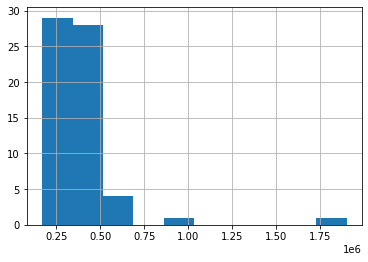

In [18]:
df['price'].hist()

## Bed vs Bath

<AxesSubplot:xlabel='bed', ylabel='bath'>

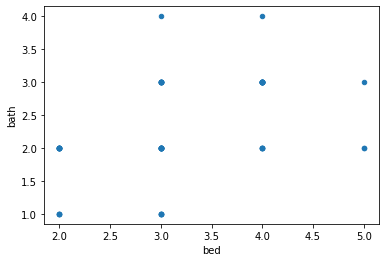

In [19]:
df.plot.scatter(x='bed',y='bath')